## Using Machine Learning to predict the age of Abalone based on the physical measurements.


### Abalone Data Set

Data set aavailable at https://archive.ics.uci.edu/ml/datasets/Abalone

#### Abstract:
    
    Predict the age of abalone from physical measurements


#### Data Set Information:

    Predicting the age of abalone from physical measurements. The age of abalone is determined by cutting the shell through the cone, staining it, and counting the number of rings through a microscope -- a boring and time-consuming task. Other measurements, which are easier to obtain, are used to predict the age. Further information, such as weather patterns and location (hence food availability) may be required to solve the problem.

    From the original data examples with missing values were removed (the majority having the predicted value missing), and the ranges of the continuous values have been scaled for use with an ANN (by dividing by 200).

#### Attribute Information:

Given is the attribute name, attribute type, the measurement unit and a brief description. The number of rings is the value to predict: either as a continuous value or as a classification problem.

 - Name / Data Type / Measurement Unit / Description

   - Sex / nominal / -- / M, F, and I (infant)
   - Length / continuous / mm / Longest shell measurement
   - Diameter / continuous / mm / perpendicular to length
   - Height / continuous / mm / with meat in shell
   - Whole weight / continuous / grams / whole abalone
   - Shucked weight / continuous / grams / weight of meat
   - Viscera weight / continuous / grams / gut weight (after bleeding)
   - Shell weight / continuous / grams / after being dried
   - Rings / integer / -- / +1.5 gives the age in years

In [169]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LinearRegression, Ridge
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.ensemble import GradientBoostingRegressor

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, accuracy_score

from sklearn.model_selection import cross_val_score, KFold, cross_validate
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

from sklearn.decomposition import PCA

seed = np.random.randint(100)
#83
np.random.seed(seed)

%matplotlib inline
plt.style.use('ggplot')

import warnings
warnings.filterwarnings('ignore')

In [66]:
col_names = ['sex', 'length', 'diameter', 'height', 'whole_weight', 'shucked_weight', 'viscera_weight', 'shell_weight', 'rings']
df = pd.read_csv('data/abalone.data', header=None, names=col_names)

In [67]:
df.head()

,sex,length,diameter,height,whole_weight,shucked_weight,viscera_weight,shell_weight,rings
0,M,0.455,0.365,0.095,0.5140,0.2245,0.1010,0.150,15
1,M,0.350,0.265,0.090,0.2255,0.0995,0.0485,0.070,7
2,F,0.530,0.420,0.135,0.6770,0.2565,0.1415,0.210,9
3,M,0.440,0.365,0.125,0.5160,0.2155,0.1140,0.155,10
4,I,0.330,0.255,0.080,0.2050,0.0895,0.0395,0.055,7


In [68]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4177 entries, 0 to 4176
Data columns (total 9 columns):
sex               4177 non-null object
length            4177 non-null float64
diameter          4177 non-null float64
height            4177 non-null float64
whole_weight      4177 non-null float64
shucked_weight    4177 non-null float64
viscera_weight    4177 non-null float64
shell_weight      4177 non-null float64
rings             4177 non-null int64
dtypes: float64(7), int64(1), object(1)
memory usage: 293.8+ KB


As per the description

    Age = number of rings + 1.5

In [69]:
df['age'] = df.rings + 1.5

In [70]:
df.head()

,sex,length,diameter,height,whole_weight,shucked_weight,viscera_weight,shell_weight,rings,age
0,M,0.455,0.365,0.095,0.5140,0.2245,0.1010,0.150,15,16.5
1,M,0.350,0.265,0.090,0.2255,0.0995,0.0485,0.070,7,8.5
2,F,0.530,0.420,0.135,0.6770,0.2565,0.1415,0.210,9,10.5
3,M,0.440,0.365,0.125,0.5160,0.2155,0.1140,0.155,10,11.5
4,I,0.330,0.255,0.080,0.2050,0.0895,0.0395,0.055,7,8.5


In [71]:
df.groupby('sex')['rings'].describe()

,count,mean,std,min,25%,50%,75%,max
sex,,,,,,,,
F,1307.0,11.129304,3.104256,5.0,9.0,10.0,12.0,29.0
I,1342.0,7.890462,2.511554,1.0,6.0,8.0,9.0,21.0
M,1528.0,10.705497,3.026349,3.0,9.0,10.0,12.0,27.0


In [72]:
df.groupby('sex').mean()

,length,diameter,height,whole_weight,shucked_weight,viscera_weight,shell_weight,rings,age
sex,,,,,,,,,
F,0.579093,0.454732,0.158011,1.046532,0.446188,0.230689,0.302010,11.129304,12.629304
I,0.427746,0.326494,0.107996,0.431363,0.191035,0.092010,0.128182,7.890462,9.390462
M,0.561391,0.439287,0.151381,0.991459,0.432946,0.215545,0.281969,10.705497,12.205497


#### Female Abalones seem to live longer from the statistics

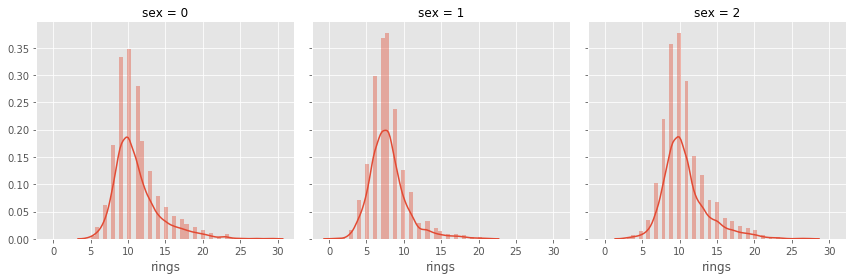

In [207]:
g = sns.FacetGrid(data = df, col = 'sex', height=4)
g = g.map(sns.distplot, 'rings')

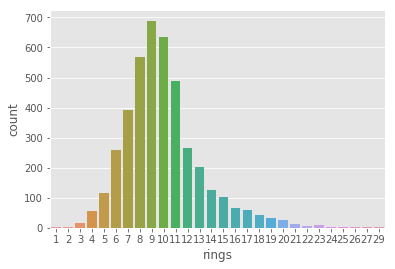

In [148]:
sns.countplot(df.rings)

Data corresponding to Abalones of ages between 5 and 15 is high. This may cause an imbalance and might effect the predictions.

Encoding the categorical columns into numerical columns

In [75]:
le = LabelEncoder()
df['sex'] = le.fit_transform(df.sex)

Selecting the input features and Target variable.

In [183]:
X = df.drop(['rings', 'age'], axis = 1)
y = df[['rings']]

Splitting the data into Training and Test sets

In [184]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state = seed)

Evaluating peformance of different models before selecting and tuning the desired model.

In [185]:
models = []

models.append(('LR', LinearRegression()))
models.append(('RidgeR', Ridge()))
models.append(('DTR', DecisionTreeRegressor()))
models.append(('RFR', RandomForestRegressor()))
models.append(('SVR', SVR()))
models.append(('GBR', GradientBoostingRegressor()))

results = []
names = []
scoring = ['neg_mean_squared_error', 'r2']
for name, model in models:
    kfold = KFold(n_splits=5, random_state=seed)
    cv_results = cross_validate(model, X_train, y_train, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = "%s: ,MSE :%f ,R2 :%f" % (name, cv_results['test_neg_mean_squared_error'].mean(), cv_results['test_r2'].mean())
    print(msg)

LR: ,MSE :-5.092725 ,R2 :0.502581
RidgeR: ,MSE :-5.059756 ,R2 :0.505205
DTR: ,MSE :-9.112274 ,R2 :0.106638
RFR: ,MSE :-5.298680 ,R2 :0.480349
SVR: ,MSE :-6.200918 ,R2 :0.398449
GBR: ,MSE :-4.897401 ,R2 :0.520482


Linear Regression, Ridge and Random Forest Regressor models have a high r2_score. Also Gradient Bosting Regressor is having the highest r2_score.

Selecting Random Forest Regressor and Gradient Boosting Regressor for making predictions

In [186]:
def train_predict_plot(model, plot_train = False):
    """
    - Fits the model to training set
    - Makes predictions on Testing set
    - Prints Evaluation Metrics
    - Plots predictions vs True values"""
   
    
    model.fit(X_train, y_train)

    y_pred_on_train = model.predict(X_train)
    y_pred = model.predict(X_test)

    print('Mean Absolute Error -', mean_absolute_error(y_test, y_pred))
    print('Mean Squared Error -', mean_squared_error(y_test, y_pred))
    print('R2 Score - ', r2_score(y_test, y_pred))
    
    if plot_train:
        plt.scatter(y_train, y_pred_on_train, label = 'Training Data')
    plt.scatter(y_test, y_pred, label = 'Testing Data')
    plt.xlabel('True')
    plt.ylabel('Predicted')
    plt.plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=2)
    plt.title('{}\n Predicted vs Actual'.format(str(type(model)).replace('.', ' ').replace('>', ' ').replace("'", ' ').split(' ')[-3]))
    plt.legend()
    plt.show()

Mean Absolute Error - 1.5428644801195448
Mean Squared Error - 4.69760849864013
R2 Score -  0.5565938707937961


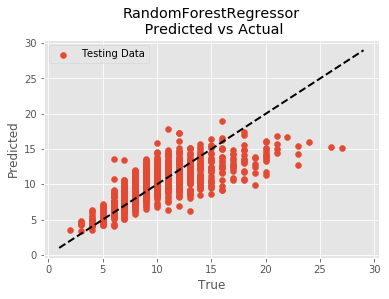

In [187]:
rfr = RandomForestRegressor(n_estimators=200, max_depth=8, random_state=seed)
train_predict_plot(rfr)

Mean Absolute Error - 1.570829952098477
Mean Squared Error - 4.900283648086958
R2 Score -  0.5374634124917639


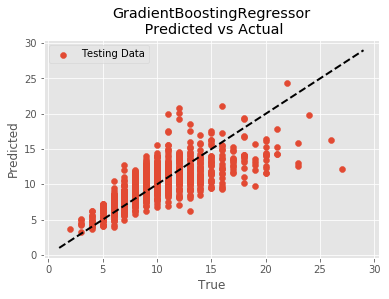

In [189]:
gbr = GradientBoostingRegressor(n_estimators=300, random_state=seed)
train_predict_plot(gbr)

Addressing the Imbalance in data

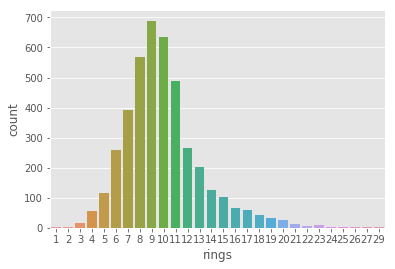

In [190]:
sns.countplot(df.rings)

Data corresponding to Abalones of ages less than 3 and more than 24 is comparitively very low. Resampling methods can be used to duplicate the data. 

In [191]:
# Dividing the data into majority and minority cases
df_temp = df[df['rings'] <= 23]
df_majority = df_temp[3 <= df['rings']]

df_minority_1 = df[df['rings'] <= 2]
df_minority_2 = df[df['rings'] >= 24]

df_minority = pd.concat([df_minority_1, df_minority_2])

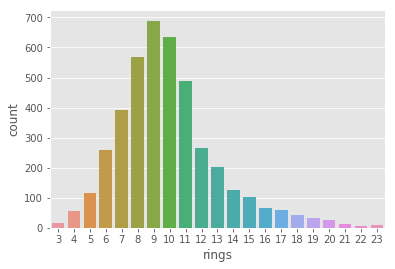

In [192]:
sns.countplot(df_majority.rings)

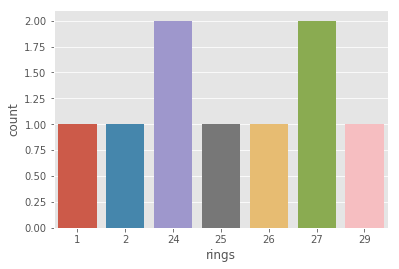

In [193]:
sns.countplot(df_minority.rings)

As seen Only one sample of each age is available for the model to train on. Now resampling the minority data.

In [194]:
from sklearn.utils import resample


df_minority_upsampled = resample(df_minority, replace=True, n_samples=1000, random_state=42)
df_majority_undersampled = resample(df_majority, replace=False, n_samples=100, random_state=42)

df_upsampled = pd.concat([df_majority, df_minority_upsampled])


In [196]:
X = df_upsampled.drop(['rings', 'age'], axis = 1)
y = df_upsampled[['rings']]

In [197]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state = seed)

Mean Absolute Error - 1.262357008596098
Mean Squared Error - 3.779656227886489
R2 Score -  0.9171540986176543


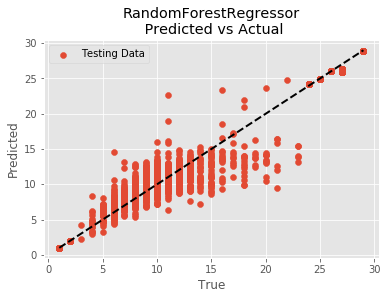

In [198]:
rfr = RandomForestRegressor(n_estimators=200, max_depth=8, random_state=seed)
train_predict_plot(rfr)

Mean Absolute Error - 1.2860431642867953
Mean Squared Error - 3.9827958301397723
R2 Score -  0.9127015022860203


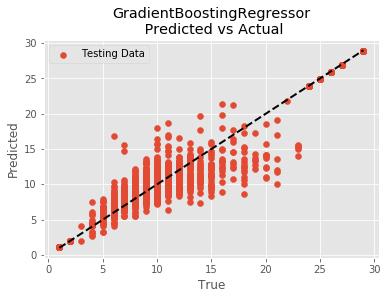

In [200]:
gbr = GradientBoostingRegressor(n_estimators=300, random_state=seed)
train_predict_plot(gbr)

There is a significant improvement in predicting these minority classes. Also the R2 Score is boosted by upsampling the minority data.